### extend the prgram dependency graph to k-hop inter procedural call

In [1]:
# specify how many hops you want to extend the current graph to
# 0 means no extension
khop = 1

In [2]:
import pickle
import re
from igraph import *

def append_to_graph(g0, g1, conns=None):
    # append a graph to another graph
    # by provided connection: (original node id, new node id)
    g = Graph()
    nv0 = len(g0.vs)
    nv1 = len(g1.vs)
    # add vertices
    g.add_vertices([i for i in range(nv0+nv1)])
    # copy attributes
    for i in range(nv0):
        for dkey in g0.vs[i].attributes().keys():
            g.vs[i][dkey] = g0.vs[i][dkey]
    for i in range(nv1):
        for dkey in g1.vs[i].attributes().keys():
            g.vs[i+nv0][dkey] = g1.vs[i][dkey]
    # add edges
    for e in g0.es:
        g.add_edges([e.tuple])
    for e in g1.es:
        # ascend the index
        g.add_edges([ tuple([e0+nv0 for e0 in e.tuple]) ])
    # add the connection
    if conns is not None:
        for c in conns:
            g.add_edges([ tuple([c[0], c[1]+nv0]) ])
    return g

def find_function_node(g0):
    # return the id of function node of a graph
    ids = []
    for dv in g0.vs:
        if dv["type"] == "Function":
            ids.append(dv.index)
    # fixme: there could be multiple Function type
    # assert len(ids) == 1
    assert len(ids) >= 1
    return ids[0]

def find_function_calls(c0):
    c0list = re.split("=", c0)
    c0list = [p.strip() for p in c0list]
    c0list = [p for p in c0list if len(p)>0]
    retlist = []
    for cc in c0list:
        retlist += re.findall(r"(.*?)\(", cc)
    retlist = [p.strip() for p in retlist]
    retlist = [p for p in retlist if len(p)>0]
    return retlist

def rec_extend_graph(arg_folder, arg_file, arg_k, arg_backward=False, arg_verbose=False):
    if arg_k <= 0:
        # no need to extend
        return arg_file
    
    file_list = list(arg_folder.keys())
    # print("file_list: {}".format(file_list))
    
    dgraph = arg_file
    d_exgraphs = [] # external graphs that should be connected
    d_conns = [] # connection tuples corresponding to external graphs
    
    # explore methods called / callee
    # forward edge
    for dv in dgraph.vs:
        if dv["type"] == "Function":
            # skip function signature node
            continue
        if "print" in dv["code"]:
            # skip print operation
            continue
        # dcalls = re.findall(r"(.*?)\(", dv["code"])
        dcalls = find_function_calls(dv["code"])
#         if arg_verbose:
#             print("# dcalls: {}".format(dcalls))
        dfiles = []
        # match method name with file name(s)
        for dc in dcalls:
            mfiles = []
            for df in file_list:
                # if dc in df:
                if dc == df.rsplit("_", 1)[0]:
                    mfiles.append(df)
            # fixme: if there are multiple matches, pick the shortest one
            if len(mfiles)>0:
                if arg_verbose:
                    print("# ({}) matched {} to {}".format(len(mfiles), dc, min(mfiles, key=len)))
                dfiles.append(min(mfiles, key=len))
            else:
                # fixme: can't find matched files, should log out errors/warnings
                if arg_verbose:
                    print("# can't find matching file for method: {}, skip".format(dc))
                pass
        # then append the external graphs and corresponding connections
        for df in dfiles:
            # detect whether the graph is empty or not before adding
            if arg_folder[df].vs is None:
                continue
            if len(arg_folder[df].vs) == 0:
                continue
#             if arg_verbose:
#                 print("# adding external graph: {}".format(df))
            if arg_k == 1:
                # end of k-hop, just append
                d_exgraphs.append(arg_folder[df])
            else:
                # extend k-hop
                kgraph = rec_extend_graph(arg_folder, arg_folder[df], arg_k-1)
                d_exgraphs.append(kgraph)
            # note: the first vertex is not always the function node, so we need to find it out
            d_conns.append((dv.index, find_function_node(arg_folder[df])))
            
    # explore methods calling / caller
    # backward edge
    # fixme: this is not super efficient but whatever
    # fixme: backward edge is always 1-hop
    if arg_backward:
        for dv in dgraph.vs:
            if dv["type"] == "Function":
                dcall0 = dv["code"] # exact function to look for
                if arg_verbose:
                    print("# backward search for: {}".format(dcall0))

                # look for calls
                for df in file_list:
                    for i in range(len(arg_folder[df].vs)):
                        # dcalls = re.findall(r"(.*?)\(", arg_folder[df].vs[i]["code"])
                        dcalls = find_function_calls(arg_folder[df].vs[i]["code"])
                        if dcall0 in dcalls:
                            if arg_verbose:
                                print("# [backward] found caller: {}".format(df))
                            d_exgraphs.append(arg_folder[df])
                            d_conns.append((dv.index, arg_folder[df].vs[i].index))

                # fixme: only deal with the first Function node
                #        since others may be appended from extended graphs
                break
    
    # then compose the final graph
    ret_graph = dgraph
    for i in range(len(d_exgraphs)):
#         if arg_verbose:
#             print("# merging external graph: {}".format(i))
        ret_graph = append_to_graph(ret_graph, d_exgraphs[i], [d_conns[i]])
    
    return ret_graph

In [42]:
curr_dir = "014"
with open("../SARD_pkl/pdg_db_dir{}.pkl".format(curr_dir), "rb") as f:
    dt = pickle.load(f)

In [43]:
# start extending the graph to k-hop
new_dt = {}
for dfolder in dt.keys():
    # print("# processing folder: {}".format(dfolder))
    print("\r# processing {}/{}".format(len(new_dt.keys()), len(dt.keys())), end="")
    new_dt[dfolder] = {}
    for dfile in dt[dfolder].keys():
        new_dt[dfolder][dfile] = rec_extend_graph(
            dt[dfolder], 
            dt[dfolder][dfile], 
            khop, 
            arg_backward=True, 
            arg_verbose=False
        )

# processing 999/1000

In [44]:
# with open("../SARD_pkl/pdg_db_dir{}_{}hop.pkl".format(curr_dir, khop), "wb") as f:
#     pickle.dump(new_dt, f)
with open("../SARD_pkl/pdg_db_dir{}_{}hop_with_backward.pkl".format(curr_dir, khop), "wb") as f:
    pickle.dump(new_dt, f)

In [32]:
list(dt["120808"].keys())

['goodG2B_382963',
 'bad3_384145',
 'CWE78_OS_Command_Injection__wchar_t_connect_socket_w32spawnl_61_bad_382900',
 'CWE78_OS_Command_Injection__wchar_t_connect_socket_w32spawnl_61b_goodG2BSource_383426',
 'CWE78_OS_Command_Injection__wchar_t_connect_socket_w32spawnl_61b_badSource_383108',
 'good7_384110',
 'good5_384096',
 'globalReturnsTrueOrFalse_384041',
 'printShortLine_383521',
 'good2_384075',
 'main_383036',
 'bad4_384152',
 'bad5_384159',
 'good3_384082',
 'printHexCharLine_383621',
 'printFloatLine_383541',
 'bad9_384187',
 'printLine_383448',
 'good4_384089',
 'bad7_384173',
 'bad2_384138',
 'printIntLine_383501',
 'printLongLongLine_383581',
 'bad6_384166',
 'globalReturnsTrue_384023',
 'printSizeTLine_383601',
 'printBytesLine_383771',
 'printWLine_383475',
 'globalReturnsFalse_384032',
 'good9_384124',
 'good8_384117',
 'bad8_384180',
 'printWcharLine_383641',
 'printDoubleLine_383722',
 'printUnsignedLine_383682',
 'decodeHexWChars_383926',
 'printStructLine_383742',
 'de

In [44]:
# find_function_calls("data = CWE78_OS_Command_Injection__wchar_t_connect_socket_w32spawnl_61b_badSource ( data )")

In [34]:
dt["120808"]["CWE78_OS_Command_Injection__wchar_t_connect_socket_w32spawnl_61_bad_382900"].vs[1]

igraph.Vertex(<igraph.Graph object at 0x7fb91c9cf040>, 1, {'code': 'data = CWE78_OS_Command_Injection__wchar_t_connect_socket_w32spawnl_61b_badSource ( data )', 'name': '382924', 'filepath': '/opt/ReSySeVR/data/SARD/dir_001/120808/CWE78_OS_Command_Injection__wchar_t_connect_socket_w32spawnl_61a.c', 'location': '68:4:1830:1917', 'type': 'ExpressionStatement', 'functionId': '382900', 'label_size': 10})

In [62]:
# gg = dt["120808"]["CWE78_OS_Command_Injection__wchar_t_connect_socket_w32spawnl_61_bad_382900"]
# gg = dt["120808"]["main_383036"]
gg = dt["120808"]["CWE78_OS_Command_Injection__wchar_t_connect_socket_w32spawnl_61b_badSource_383108"]

In [58]:
gg = rec_extend_graph(dt["120808"], dt["120808"]["CWE78_OS_Command_Injection__wchar_t_connect_socket_w32spawnl_61_bad_382900"], 1, arg_backward=False, arg_verbose=True)
# gg = rec_extend_graph(dt["120808"], dt["120808"]["main_383036"], 1, arg_verbose=True)

# (1) matched CWE78_OS_Command_Injection__wchar_t_connect_socket_w32spawnl_61b_badSource to CWE78_OS_Command_Injection__wchar_t_connect_socket_w32spawnl_61b_badSource_383108
# can't find matching file for method: _wspawnl, skip


In [63]:
len(gg.vs)

37

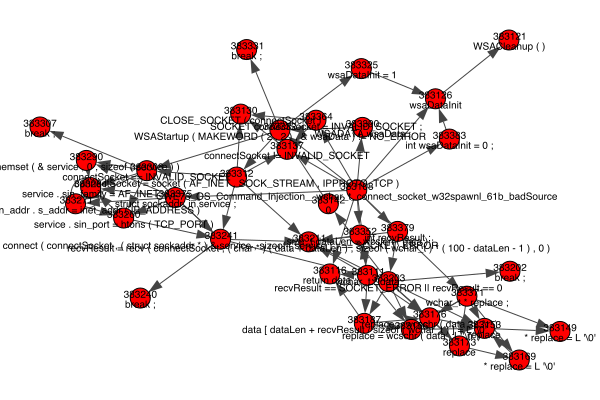

In [64]:
for p in gg.vs:
    p["label_size"]=10
visual_style = {}
visual_style["margin"]=40
visual_style["bbox"]=(600,400)
visual_style["vertex_label"] = [
    "{} \n {}".format(gg.vs["name"][i], gg.vs["code"][i]) 
    for i in range(len(gg.vs["code"]))
]
plot(gg, **visual_style)